# Modèle non linéaire - LOSS FUNCTION

Ici on reprend tout ce qu'on a fait, mais on change la loss.

On utilise la distance de Wasserstein (transport optimal), calculé par un algorithme de Sinkorhn. 

Elle est directement reprise d'un repo dans adaptation, elle ne correspond pas à notre modèle.

In these variables, Sinkhorn algorithm can be interpreted as an alternate maximization algorithm, to solve the following "dual" problem:
$$
\max_{f\in R^n, g \in R^m} F(f,g) =  \sum_{i=1}^n f_i a_i + \sum_{j=1}^m g_j b_j - \epsilon \sum_{i,j} a_ib_j \exp \left( (f_i + g_j -C_{ij})/\epsilon \right).
$$

In these variables, the algorithm is initialized with $g = 0_m$ and the updates read
$$
f_i \longleftarrow - \epsilon \log \sum_{j} b_j \exp ((g_j - C_{ij})/\epsilon),\, \forall i \\
g_j \longleftarrow - \epsilon \log \sum_{i} a_i \exp ((f_i - C_{ij})/\epsilon),\, \forall j
$$

In [3]:
import numpy as np
# pytorch
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from torch.nn.modules.loss import _Loss
import torch
from torch.autograd import Variable
# matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


In [5]:
# Physical data
l = 200
tau = 100
dep = 2
# Numerical data
nx = 200
dx = l/(nx+1)
nt = 200
dt = tau/nt
T_operator = 1/100*dx*np.tri(nt, nx, 0, dtype=int)
# Data sample
nsamp = 400
x_dagger = np.zeros((nsamp,nx))
y = np.zeros((nsamp,nt))
x_grid = np.linspace(0,l,nx)
#
x_sample = np.zeros((nsamp,nx))
#
for i in range(0,nsamp):
    mu = l/2
    sigma = 0.1
    x_dagger[i] = (sigma*np.sqrt(2*np.pi))**-1*np.exp(-(x_grid-mu)**2/2*sigma**2)
    x_dagger[i] = x_dagger[i]/x_dagger[i].sum()
    y[i] = T_operator.dot(x_dagger[i]) 
    xi = np.random.uniform(-0.005,0.005,nt)
    y[i] += xi*np.linalg.norm(y[i])/np.linalg.norm(xi)
    x_sample[i] = np.transpose(T_operator).dot(y[i])

In [6]:
# Regularisation operator
D_operator = np.diag(np.ones(nx-1),1)+ np.diag(np.ones(nx-1),-1)-2*np.eye(nx)

In [7]:
x_tensor = torch.from_numpy(x_sample)
y_tensor = torch.from_numpy(x_dagger)

dataset = TensorDataset(x_tensor, y_tensor)

train_dataset, val_dataset = random_split(dataset, [300, 100])

train_loader = DataLoader(dataset=train_dataset, batch_size=16)
val_loader = DataLoader(dataset=val_dataset, batch_size=20)

## Model

In [8]:
class MyModel(nn.Module):
    def __init__(self, number_of_layers, T, D, nx):
        super().__init__()
        self.alpha = [nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))\
                      for k in range(number_of_layers)]
#         self.linear_output_transformation = nn.Linear(weight_dimensions, number_of_classes,\
#                                                       bias=False)
        self.activation_function = nn.Tanh()  
        self.activation_function_ter = nn.ReLU() 
        self.number_of_layers = number_of_layers
        # Physical model
        self.T = torch.from_numpy(np.transpose(T).dot(T))
        self.D = torch.from_numpy(np.transpose(D).dot(D))
        self.nx = nx
        
    
    def forward(self, x):
        y = torch.transpose(x,0,-1)
        for k in range(self.number_of_layers):
            tensor_grad = torch.eye(nx)\
              - self.T \
              - self.alpha[k]*self.D
            y = torch.matmul(tensor_grad,y)
            y = self.activation_function(y)
        y = self.activation_function_ter(y)
        y = y/torch.sum(y)
        return torch.transpose(y,0,-1)

In [9]:
model = MyModel(10, T_operator, D_operator, nx)

In [10]:
y_pred = model(train_dataset[0][0])
y_test = train_dataset[0][1]

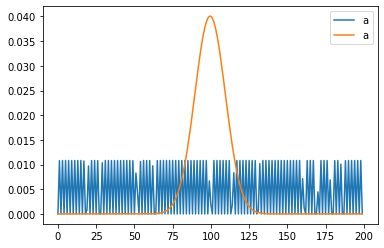

In [11]:
plt.plot(y_pred.detach().numpy(),label="a")
plt.plot(y_test,label="a")
plt.legend()

## Loss function

In [169]:
"""
sinkhorn_pointcloud.py
Discrete OT : Sinkhorn algorithm for point cloud marginals.
"""


def sinkhorn_normalized(x, y, epsilon, n, niter):

    Wxy = sinkhorn_loss(x, y, epsilon, n, niter)
    Wxx = sinkhorn_loss(x, x, epsilon, n, niter)
    Wyy = sinkhorn_loss(y, y, epsilon, n, niter)
    return 2 * Wxy - Wxx - Wyy


def sinkhorn_loss(x, y, epsilon, n, niter):
    """
    Given two emprical measures with n points each with locations x and y
    outputs an approximation of the OT cost with regularization parameter epsilon
    niter is the max. number of steps in sinkhorn loop
    """

    # The Sinkhorn algorithm takes as input three variables :
    C = Variable(cost_matrix(x, y))  # Wasserstein cost function

    # both marginals are fixed with equal weights
    # mu = Variable(1. / n * torch.cuda.FloatTensor(n).fill_(1), requires_grad=False)
    # nu = Variable(1. / n * torch.cuda.FloatTensor(n).fill_(1), requires_grad=False)
    mu = Variable(1. / n * torch.FloatTensor(n).fill_(1), requires_grad=False)
    nu = Variable(1. / n * torch.FloatTensor(n).fill_(1), requires_grad=False)

    # Parameters of the Sinkhorn algorithm.
    rho = 1  # (.5) **2          # unbalanced transport
    tau = -.8  # nesterov-like acceleration
    lam = rho / (rho + epsilon)  # Update exponent
    thresh = 10**(-1)  # stopping criterion

    # Elementary operations .....................................................................
    def ave(u, u1):
        "Barycenter subroutine, used by kinetic acceleration through extrapolation."
        return tau * u + (1 - tau) * u1

    def M(u, v):
        "Modified cost for logarithmic updates"
        "$M_{ij} = (-c_{ij} + u_i + v_j) / \epsilon$"
        return (-C + u.unsqueeze(1) + v.unsqueeze(0)) / epsilon

    def lse(A):
        "log-sum-exp"
        return torch.log(torch.exp(A).sum(1, keepdim=True) + 1e-6)  # add 10^-6 to prevent NaN

    # Actual Sinkhorn loop ......................................................................
    u, v, err = 0. * mu, 0. * nu, 0.
    actual_nits = 0  # to check if algorithm terminates because of threshold or max iterations reached

    for i in range(niter):
        u1 = u  # useful to check the update
        u = epsilon * (torch.log(mu) - lse(M(u, v)).squeeze()) + u
        v = epsilon * (torch.log(nu) - lse(M(u, v).t()).squeeze()) + v
        # accelerated unbalanced iterations
        # u = ave( u, lam * ( epsilon * ( torch.log(mu) - lse(M(u,v)).squeeze()   ) + u ) )
        # v = ave( v, lam * ( epsilon * ( torch.log(nu) - lse(M(u,v).t()).squeeze() ) + v ) )
        err = (u - u1).abs().sum()

        actual_nits += 1
        if (err < thresh).data.numpy():
            break
    U, V = u, v
    pi = torch.exp(M(U, V))  # Transport plan pi = diag(a)*K*diag(b)
    C_ter = cost_matrix(x, y)
    cost = torch.sum(pi * C_ter)  # Sinkhorn cost

    return cost


def cost_matrix(x, y, p=2):
    "Returns the matrix of $|x_i-y_j|^p$."
    x_col = x.unsqueeze(1)
    y_lin = y.unsqueeze(0)
    c = torch.sum((torch.abs(x_col - y_lin)) ** p, 1) # Attention dimension de la somme à vérifier
    return c

In [170]:
class My_loss(_Loss):
    def __init__(self): 
        super(My_loss, self).__init__()
        self.epsilon = 0.01
        self.n = 1
        self.niter = 1000
 
    def forward(self, output, target):
        computed_loss = sinkhorn_loss(output, target, self.epsilon, self.n, self.niter)
        return computed_loss

In [171]:
loss_fn = My_loss()

In [172]:
y_pred = model(train_dataset[12][0])
y_test = train_dataset[12][1]
loss_fn(y_pred,y_test)

tensor(3.2011e-98, dtype=torch.float64, grad_fn=<SumBackward0>)

## Training

In [173]:
lr = 1e-1
# Defines a SGD optimizer to update the parameters
optimizer = optim.SGD(model.alpha, lr=lr)

In [174]:
def make_train_step(model, loss_fn, optimizer):
    # Builds function that performs a step in the train loop
    def train_step(x, y):
        # Sets model to TRAIN mode
        model.train()
        # Makes predictions
        yhat = model(x)
        # Computes loss
        loss = loss_fn(y, yhat)
        # Computes gradients
        loss.backward()
        # Updates parameters and zeroes gradients
        optimizer.step()
        optimizer.zero_grad()
        # Returns the loss
        return loss.item()
    
    # Returns the function that will be called inside the train loop
    return train_step

In [175]:
# Creates the train_step function for our model, 
# loss function and optimizer
train_step = make_train_step(model, loss_fn, optimizer)

In [176]:
losses = []
val_losses = []
n_epochs = 10
device = 'cuda' if torch.cuda.is_available() else 'cpu'

for epoch in range(n_epochs):
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        loss = train_step(x_batch, y_batch)
        losses.append(loss)
        
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            
            model.eval()

            yhat = model(x_val)
            val_loss = loss_fn(y_val, yhat)
            val_losses.append(val_loss.item())

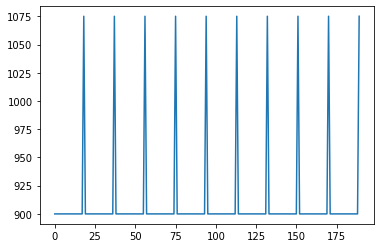

In [177]:
plt.plot(losses)

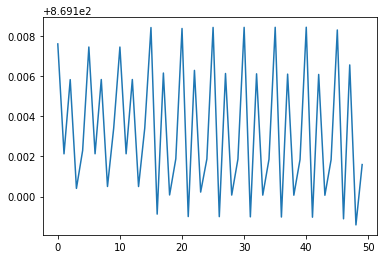

In [178]:
plt.plot(val_losses)